# Adverse Human Behaviour (AHB)

Does OpenAI already know how to classify if a tweet is talking about 'Drugs Abuse / Drugs Consumption' (one of the AHB problems)?

## Install and import dependencies

In [1]:
import os
import re

from openai import OpenAI

import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

plt.style.use('../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Print out the versions of the libraries that I'm using for future reference

In [2]:
%watermark -n -v -m -iv

Python implementation: CPython
Python version       : 3.13.0
IPython version      : 9.4.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 23.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

sklearn   : 1.7.1
matplotlib: 3.10.5
watermark : 2.5.0
pandas    : 2.3.1
seaborn   : 0.13.2
re        : 2.2.1
sys       : 3.13.0 (main, Oct  7 2024, 05:02:14) [Clang 16.0.0 (clang-1600.0.26.4)]
openai    : 1.99.6
tqdm      : 4.67.1



## Initialize OpenAI client

In [3]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

## Tweets Classifier

First, we define the function to classify the tweet.

In [9]:
def classify_tweet(tweet):
    prompt = f"""
    Clasifica el siguiente tweet como POSITIVE o NEGATIVE según estos criterios:

    POSITIVE: cumple con uno o más de los siguientes:
    - El usuario del tweet habla de cómo o qué tipo de droga ilícita está consumiendo.
    - El usuario del tweet expresa la necesidad de consumir drogas ilícitas, ya sea por abstinencia o por gusto.
    - El usuario añora consumir drogas ilícitas.

    NEGATIVE: no cumple con ningún criterio POSITIVE, por ejemplo:
    - Habla sobre noticias o información general sobre drogas ilícitas.
    - Menciona drogas ilícitas sin relación con consumo problemático o necesidad.
    - Expresa ironía o sarcasmo relacionado con drogas ilícitas.

    Tener en cuenta los siguientes aspectos:
    - En el tweet puede estar presente la ironía o sarcasmo.
    - El análisis se centra en el autor del tweet. Por ejemplo, si el tweet cita a otro usuario y le pregunta si ha consumido drogas, o si habla en nombre de otro usuario mencionando que ese usuario consume drogas, la clasificación del tweet debe ser NEGATIVE, ya que el contenido no involucra directamente al autor.
    - Algunos tweets mencionan tomar una línea de colectivo, subte o tren, pero solamente esto, no es condición suficiente para interpretarlo como una referencia al consumo de drogas ilícitas.

    Responde únicamente con la palabra POSITIVE o NEGATIVE, sin añadir explicaciones ni otro texto.

    Tweet: {tweet}
    """

    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[
            {"role": "system", "content": "Sos un clasificador binario de tweets que hablan sobre drogas ilícitas"},
            {"role": "user", "content": prompt}
        ],
        temperature=1
    )

    return response.choices[0].message.content.strip().upper()

After that, we define the function to create a tweet with all the needed context

In [10]:
def build_tweet_context(row):
    context_parts = []

    if pd.notna(row.get("tweet_author")):
        context_parts.append(f"Autor del tweet: {row['tweet_author']}")
    if pd.notna(row.get("tweet_avatar")):
        context_parts.append(f"Avatar del tweet: {row['tweet_avatar']}")

    if pd.notna(row.get("tweet_text")):
        context_parts.append(f"Texto del tweet: {row['tweet_text']}")

    if pd.notna(row.get("tweet_images")) and str(row["tweet_images"]).strip():
        context_parts.append(f"Imágenes del tweet: {row['tweet_images']}")

    if pd.notna(row.get("is_tweet_a_reply")) and row["is_tweet_a_reply"] is True:
        context_parts.append("Este tweet es una respuesta a otro tweet.")

    if pd.notna(row.get("quote_author")):
        context_parts.append(f"Autor del tweet citado: {row['quote_author']}")
    if pd.notna(row.get("quote_avatar")):
        context_parts.append(f"Avatar del tweet citado: {row['quote_avatar']}")
    if pd.notna(row.get("quote_text")):
        context_parts.append(f"Texto del tweet citado: {row['quote_text']}")
    if pd.notna(row.get("quote_images")) and str(row["quote_images"]).strip():
        context_parts.append(f"Imágenes del tweet citado: {row['quote_images']}")
    if pd.notna(row.get("is_quote_a_reply")) and row["is_quote_a_reply"] is True:
        context_parts.append("El tweet citado es una respuesta a otro tweet.")

    return "\n".join(context_parts)

Then we load the `corpus.csv` which contains manually categorized tweets, and prepare it for the classification process

In [11]:
df = pd.read_csv("../data/raw/corpus.csv")

def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.replace(" ", "_").lower()

df.columns = [to_snake_case(col) for col in df.columns]

print(df.columns)

Index(['id', 'tweet_author', 'tweet_avatar', 'tweet_text', 'tweet_images',
       'is_tweet_a_reply', 'quote_author', 'quote_avatar', 'quote_text',
       'quote_images', 'is_quote_a_reply', 'categorization'],
      dtype='object')


Fill the `tweet_context` column

In [12]:
df["tweet_context"] = df.apply(build_tweet_context, axis=1)
print(df["tweet_context"].iloc[161])

Autor del tweet: @LucasMarianook
Avatar del tweet: https://pbs.twimg.com/profile_images/1611526342247415808/4Zq9ZRxm_normal.jpg
Texto del tweet: Mayada: Que ganas de tomarme una linea, pero no tengo.

Martinez Cuarta: Yo te doy de la mía.
Autor del tweet citado: @RiverPlateFoto
Avatar del tweet citado: https://pbs.twimg.com/profile_images/877849863895080960/d9gZBQtR_mini.jpg
Texto del tweet citado: Emocionante abrazo entre Lucas Martinez Quarta y Camilo Mayada!
Imágenes del tweet citado: https://pbs.twimg.com/media/DXK_LJOWAAAova8?format=jpg&name=small


Start the classification process and save the results in a 'prediction' column

In [13]:
tqdm.pandas(desc="Classifying tweets")
df["prediction"] = df["tweet_context"].progress_apply(classify_tweet)

Classifying tweets:   0%|          | 0/1009 [00:00<?, ?it/s]

In [14]:
print(df["prediction"])

0       POSITIVE
1       POSITIVE
2       POSITIVE
3       NEGATIVE
4       POSITIVE
          ...   
1004    NEGATIVE
1005    NEGATIVE
1006    NEGATIVE
1007    NEGATIVE
1008    NEGATIVE
Name: prediction, Length: 1009, dtype: object


### Confusion Matrix

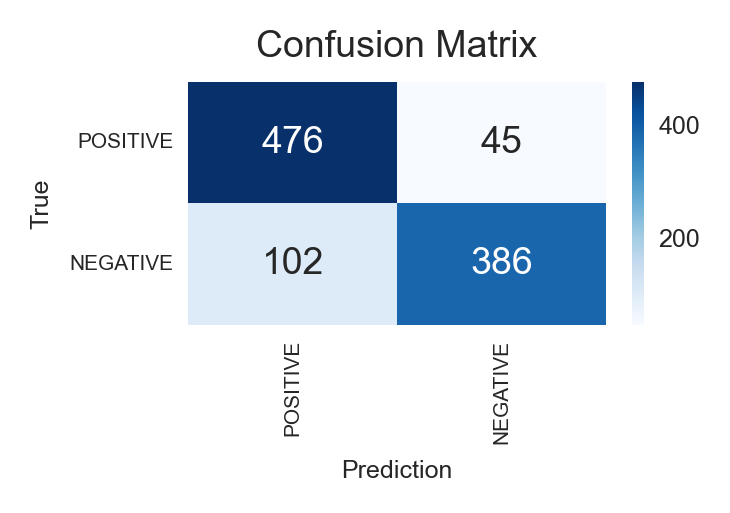

[[476  45]
 [102 386]]


In [18]:
y_true = df["categorization"]
y_pred = df["prediction"]

cm = confusion_matrix(y_true, y_pred, labels=["POSITIVE", "NEGATIVE"])

labels = ["POSITIVE", "NEGATIVE"]

plt.figure(figsize=(2,1))

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    annot_kws={"size": 9}
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

plt.xlabel('Prediction', fontsize=6)
plt.ylabel('True', fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.title('Confusion Matrix', fontsize=9)
plt.show()

print(cm)

### Classification report

In [16]:
report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("Classification report:\n")
report_df.style.format({
    'precision': '{:.2f}',
    'recall': '{:.2f}',
    'f1-score': '{:.2f}',
    'support': '{:.0f}'
})

Classification report:



,precision,recall,f1-score,support
POSITIVE,0.82,0.91,0.87,521
NEGATIVE,0.90,0.79,0.84,488
accuracy,0.85,0.85,0.85,1
macro avg,0.86,0.85,0.85,1009
weighted avg,0.86,0.85,0.85,1009


### Wrongly classified tweets

In [17]:
df["error"] = df["categorization"] != df["prediction"]
df_errors = df[df["error"]]

print(f"Wrongly classified tweets quantity: {len(df_errors)}")

wrongly_classified_tweets = df_errors[["tweet_context", "categorization", "prediction"]]

display(wrongly_classified_tweets)

wrongly_classified_tweets.to_csv("../data/processed/wct_gpt-5-mini-v2.csv", index=False)

Wrongly classified tweets quantity: 147


,tweet_context,categorization,prediction
5,Autor del tweet: @wulkan_co\nAvatar del tweet:...,POSITIVE,NEGATIVE
15,Autor del tweet: @MartaRepupilli\nAvatar del t...,POSITIVE,NEGATIVE
26,Autor del tweet: @Musaromana\nAvatar del tweet...,POSITIVE,NEGATIVE
38,Autor del tweet: @mikaelamattio\nAvatar del tw...,NEGATIVE,POSITIVE
40,Autor del tweet: @AgataEtchart\nAvatar del twe...,POSITIVE,NEGATIVE
...,...,...,...
985,Autor del tweet: @jorgecoronel\nAvatar del twe...,NEGATIVE,POSITIVE
992,Autor del tweet: @papawaca\nAvatar del tweet: ...,NEGATIVE,POSITIVE
995,Autor del tweet: @giuseppe_s\nAvatar del tweet...,NEGATIVE,POSITIVE
1003,Autor del tweet: @kokotrippy\nAvatar del tweet...,POSITIVE,NEGATIVE
